# Q1.1

## Used only sentiment and tweet columns, and converted sentiment 0 to -1, 4 to 1.

In [3]:
import pandas as pd
import numpy as np
import string

column_names = ['sentiment','tweet']
file = pd.read_csv('training.1600000.processed.noemoticon.csv', usecols = [0, 5], names = column_names, encoding='latin-1')
comp_tweet = np.asarray(file['tweet']).tolist()

file['sentiment'] = file['sentiment'].apply({0:-1, 4:1}.get)

In [4]:
np.asarray(file['sentiment'])

array([-1, -1, -1, ...,  1,  1,  1])

# Q1.2

## Read in stopwords and stored stopwords in content.

In [5]:
import pandas as pd
import numpy as np
import string

array = np.asarray(file['tweet']).tolist()
with open('stopwords.txt') as f:
    content = f.readlines()
content = [x.strip() for x in content] 

sentiment = np.asarray(file['sentiment']).tolist()

## Did data cleaning for each tweet and removed words that are stopwords.

In [6]:
import time
t0 = time.time()
listSum = []
word = []
for i in range(len(array)):
    # remove additional white space, lower case
    lower = array[i].lower()
    st = ' '.join(lower.split())
    # the first part
    str_array = st.split(',')[0].split(' ')
    list1 = []
    for y in str_array:
        # convert @
        if '@' in y:
            y = 'AT-USER'
        # convert www
        elif 'www.' in y or 'http://' in y or 'https://' in y:
            y = 'URL'
        # remove punctuation
        else:
            translator = str.maketrans('', '', string.punctuation)
            y = y.translate(translator)
        # stopword
        if y not in content:
            list1.append(y)
    word.append(list1)
    # replace duplicate words
    listSum.append((set(list1),sentiment[i]))
elapsed = (time.time() - t0)

## Obtained a table of feature vectors and sentiment.

In [8]:
listSum[0:3]

[({'awww'}, -1),
 ({'blah',
   'cant',
   'cry',
   'facebook',
   'result',
   'school',
   'texting',
   'update',
   'upset'},
  -1),
 ({'50', 'ball', 'bounds', 'dived', 'managed', 'rest', 'save', 'times'}, -1)]

# Q1.3

## Created bag of words dictionary, where key is word and value is word position.

In [10]:
# bag of words
dic = {}
tweet = set()
for i in range(len(array)):
    # remove additional white space, lower case
    lower = array[i].lower()
    st = ' '.join(lower.split())
    # the first part
    str_array = st.split(',')[0].split(' ')
    list1 = []
    for y in str_array:
        # convert @
        if '@' in y:
            y = 'AT-USER'
        # convert www
        elif 'www.' in y or 'http://' in y or 'https://' in y:
            y = 'URL'
        # remove punctuation
        else:
            translator = str.maketrans('', '', string.punctuation)
            y = y.translate(translator)
        # remove stopword
        if y not in content:
            length = len(tweet)
            tweet.add(y)
            length1 = len(tweet)
            if length != length1:
                dic[y] = length

## Used CountVectorizer to create feature vector, where dic is bag of words dictionary, and comp_tweet are the entire words from training data.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import time
t0 = time.time()
vectorizer = CountVectorizer(encoding = 'latin1', vocabulary = dic)
X = vectorizer.fit_transform(comp_tweet)
a = X
elapsed = (time.time() - t0)

In [14]:
elapsed

22.50324296951294

In [15]:
a

<1600000x389364 sparse matrix of type '<class 'numpy.int64'>'
	with 9012506 stored elements in Compressed Sparse Row format>

In [17]:
import sparse
from scipy.sparse import csr_matrix, hstack
senti = csr_matrix(np.asarray(file['sentiment'])).transpose()
b = hstack([a,senti])

## Created b: list of feature vector and sentiment attached to it.

In [18]:
b

<1600000x389365 sparse matrix of type '<class 'numpy.int64'>'
	with 10612506 stored elements in COOrdinate format>

## Q1.4

## Loaded train_data and train_label.

In [19]:
fff = b.tocsr()

train_data = fff[:,0:389363]
train_label = fff[:,389364]

## We chose lambda = 0.01, iterations = 5000, batch size = 100. Since ||w0||<=1/sqrt(lambda), we chose initial weight to be 1.

In [90]:
import random
import math
from numpy import linalg as LA
def batchPegasos(data, labels, lambd, T, b):
    train_err = []
    m,n = data.shape
    rang = np.arange(m)
    w = np.ones((1,n))
    for t in range(1,T+1):
        delta_w = np.zeros((1,n))
        # do random index in batch size
        np.random.shuffle(rang)
        eta = 1/(lambd*t)
        for k in range(b):
            # j: batch index
            j = rang[k]
            x_train = data[j,:]
            y_train = labels[j]
            if ((w*x_train.transpose())*y_train)<1:
                delta_w += (y_train)*x_train
        w=w-(eta*lambd*w-(eta/b)*delta_w)
        if 1<(1.0/(math.sqrt(lambd)*LA.norm(w))):
            w_res = w
        else:
            w_res = (1.0/(math.sqrt(lambd)*LA.norm(w)))*w
        # compute training error
        prod = np.sign(data*w_res.transpose())
        error = 1-(np.sum(prod==labels)/labels.size)
        train_err.append(error)
    return train_err           

In [92]:
import time
t0 = time.time()
final_res_4 = batchPegasos(train_data,train_label,0.01,5000,100)
elapsed = (time.time() - t0)

In [93]:
elapsed 

2734.93705701828

## From training error result, we could see that the training error converges to around 0.29 at about 2000 interations.

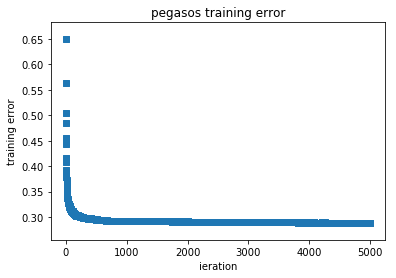

In [99]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
T = 5000
plt.scatter(np.arange(T), final_res_4, marker='s')
x = np.arange(T)
y = final_res_4
plt.title('pegasos training error')
plt.xlabel('ieration')
plt.ylabel('training error')
ax.plot(x,y)
plt.show()

## Q1.5

## We chose iterations = 5000, eta = 1e-2, fudge_factor = 1e-6, batch size = 100. Since ||w0||<=1/sqrt(lambda), we choose initial weight to be 0.

In [102]:
import random
import math
from numpy import linalg as LA
def batchAdaGrad(data,labels,T,eta,fudge_factor,batch_size):
    train_err = []
    autocorr = 0.95
    m,n = data.shape
    rang = np.arange(m)
    w = np.zeros((1,n))
    g_sq = np.zeros((1,n))
    for t in range(1,T+1):
        f_grad = np.zeros((1,n))
        np.random.shuffle(rang)
        for k in range(batch_size):
            # j: batch index
            j = rang[k]
            x_train = data[j,:]
            y_train = labels[j]
            if ((w*x_train.transpose())*y_train)<1:
                f_grad += -y_train*x_train
        f_grad = f_grad/batch_size
        if g_sq.all() == 0:
            g_sq = np.asarray(f_grad)**2
        else:
            g_sq = autocorr*g_sq + (1-autocorr)*np.asarray(f_grad)**2
        adjust_grad = f_grad / (fudge_factor + np.sqrt(g_sq))
        w=w-eta*adjust_grad
        w_res = w
        # compute error
        prod = np.sign(data*w_res.transpose())
        error = 1-(np.sum(prod==labels)/labels.size)
        train_err.append(error)
    return train_err    

In [104]:
import time
t0 = time.time()
final_res_5 = batchAdaGrad(train_data,train_label,5000,1e-2,1e-6,100)
elapsed = (time.time() - t0)

## From training error result, we could see that the training error converges to around 0.26 at about 5000 interations.

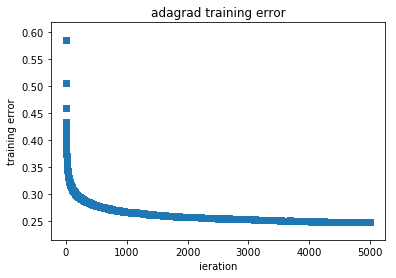

In [114]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
T = 5000
plt.scatter(np.arange(T), final_res_5, marker='s')
x = np.arange(T)
y = final_res_5
plt.title('adagrad training error')
plt.xlabel('ieration')
plt.ylabel('training error')
ax.plot(x,y)
plt.show()

## Comparing pegasos(blue) with adagrad(orange) training error, we could see that adagrad converges slower.

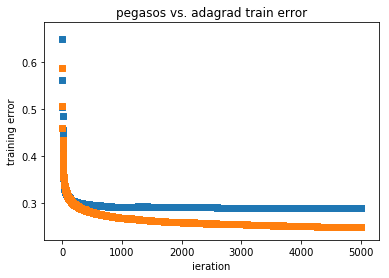

In [112]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
T = 5000
x = np.arange(T)
y1 = final_res_4
y2 = final_res_5
plt.title('pegasos vs. adagrad train error')
plt.xlabel('ieration')
plt.ylabel('training error')
plt.scatter(x,y1,marker = 's')
plt.scatter(x,y2,marker = 's')
plt.show()

In [113]:
elapsed

1430.4310948848724

## Q1.6

## For this problem, we used bag of words dictionary in training data, hence there will be a large number of 0s in feature vectors of test data.

In [42]:
import pandas as pd
import numpy as np
import string

column_names = ['sentiment','tweet']
file = pd.read_csv('training.1600000.processed.noemoticon.csv', usecols = [0, 5], names = column_names, encoding='latin-1')
comp_tweet = np.asarray(file['tweet']).tolist()
file['sentiment'] = file['sentiment'].apply({0:-1, 4:1}.get)

array = np.asarray(file['tweet']).tolist()
with open('stopwords.txt') as f:
    content = f.readlines()
content = [x.strip() for x in content] 

sentiment = np.asarray(file['sentiment']).tolist()

## Created bag of words dictionary based on training data.

In [43]:
# bag of words
dic = {}
tweet = set()
for i in range(len(array)):
    # remove additional white space, lower case
    lower = array[i].lower()
    st = ' '.join(lower.split())
    # the first part
    str_array = st.split(',')[0].split(' ')
    list1 = []
    for y in str_array:
        # @
        if '@' in y:
            y = 'AT-USER'
        # www
        elif 'www.' in y or 'http://' in y or 'https://' in y:
            y = 'URL'
        # punctuation
        else:
            translator = str.maketrans('', '', string.punctuation)
            y = y.translate(translator)
        # stopword
        if y not in content:
            length = len(tweet)
            tweet.add(y)
            length1 = len(tweet)
            if length != length1:
                dic[y] = length

## Created feature vector and sentiment of training data, in order to train pegasos and adagrad model.

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
import time
t0 = time.time()
vectorizer = CountVectorizer(encoding = 'latin1', vocabulary = dic)
X = vectorizer.fit_transform(comp_tweet)
a = X
elapsed = (time.time() - t0)

import sparse
from scipy.sparse import csr_matrix, hstack
senti = csr_matrix(np.asarray(file['sentiment'])).transpose()
b_tr = hstack([a,senti])

In [45]:
b_tr

<1600000x389365 sparse matrix of type '<class 'numpy.int64'>'
	with 10612506 stored elements in COOrdinate format>

## Created feature vector and sentiment of test data, in order to test pegasos and adagrad model and get test error.

In [46]:
column_names = ['sentiment','tweet']
file = pd.read_csv('testdata.manual.2009.06.14.csv', usecols = [0, 5], names = column_names, encoding='latin-1')
comp_tweet_test = np.asarray(file['tweet']).tolist()


file['sentiment'] = file['sentiment'].apply({0:-1, 2:1, 4:1}.get)

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
import time
t0 = time.time()
vectorizer = CountVectorizer(encoding = 'latin1', vocabulary = dic)
X = vectorizer.fit_transform(comp_tweet_test)
a = X
elapsed = (time.time() - t0)

import sparse
from scipy.sparse import csr_matrix, hstack
senti = csr_matrix(np.asarray(file['sentiment'])).transpose()
b_te = hstack([a,senti])

## Converted b_tr and b_te to csr matrix. Loaded training data, training label, test data and test labels. 

In [ ]:
ddd = b_tr.tocsr()
tr_data = ddd[:,0:389363]
tr_label = ddd[:,389364]

fff = b_te.tocsr()
te_data = fff[:,0:389363]
te_label = fff[:,389364]

## Pegasos test error

In [50]:
import random
import math
from numpy import linalg as LA
def batchPegasos(test_data, test_labels, train_data, train_labels,lambd, T, b):
    test_err = []
    m,n = train_data.shape
    rang = np.arange(m)
    w = np.ones((1,n))
    for t in range(1,T+1):
        delta_w = np.zeros((1,n))
        np.random.shuffle(rang)
        eta = 1/(lambd*t)
        for k in range(b):
            # j: batch index
            j = rang[k]
            x_train = train_data[j,:]
            y_train = train_labels[j]
            if ((w*x_train.transpose())*y_train)<1:
                delta_w += (y_train)*x_train
        w=w-(eta*lambd*w-(eta/b)*delta_w)
        if 1<(1.0/(math.sqrt(lambd)*LA.norm(w))):
            w_res = w
        else:
            w_res = (1.0/(math.sqrt(lambd)*LA.norm(w)))*w
        prod = np.sign(test_data*w_res.transpose())
        error = 1-(np.sum(prod==test_labels)/test_labels.size)
        test_err.append(error)
    return test_err

In [ ]:
import time
t0 = time.time()
final_res = batchPegasos(te_data,te_label,tr_data,tr_label,0.01,5000,100)
elapsed = (time.time() - t0)

## There is a shape decrease at first iterations. Pegasos accuracy converges to 0.75. Pegasos test error converges to around 0.25.

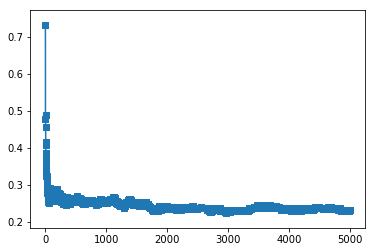

In [53]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
T = 5000
ax.scatter(np.arange(T), final_res, marker='s')
x = np.arange(T)
y = final_res
ax.plot(x,y)
plt.show()

## Adagrad test error

In [54]:
import random
import math
from numpy import linalg as LA
def batchAdaGrad(test_data, test_labels, train_data, train_labels, T,eta,fudge_factor,batch_size):
    test_err = []
    autocorr = 0.95
    m,n = train_data.shape
    rang = np.arange(m)
    w = np.zeros((1,n))
    g_sq = np.zeros((1,n))
    for t in range(1,T+1):
        f_grad = np.zeros((1,n))
        np.random.shuffle(rang)
        for k in range(batch_size):
            # j: batch index
            j = rang[k]
            x_train = train_data[j,:]
            y_train = train_labels[j]
            if ((w*x_train.transpose())*y_train)<1:
                f_grad += -y_train*x_train
        f_grad = f_grad/batch_size
        if g_sq.all() == 0:
            g_sq = np.asarray(f_grad)**2
        else:
            g_sq = autocorr*g_sq + (1-autocorr)*np.asarray(f_grad)**2
        adjust_grad = f_grad / (fudge_factor + np.sqrt(g_sq))
        w=w-eta*adjust_grad
        w_res = w
        prod = np.sign(test_data*w_res.transpose())
        error = 1-(np.sum(prod==test_labels)/test_labels.size)
        test_err.append(error)
    return test_err 

In [ ]:
import time
t0 = time.time()
final_res = batchAdaGrad(te_data,te_label,tr_data,tr_label, 5000,1e-2,1e-6,100)
elapsed = (time.time() - t0)

In [58]:
elapsed

955.3584632873535

## Adagrad accuracy converges to 0.83. Adagrad test error converges to about 0.17.

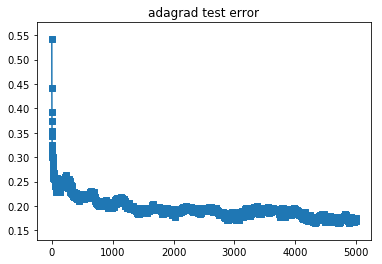

In [57]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
T = 5000
ax.scatter(np.arange(T), final_res, marker='s')
x = np.arange(T)
y = final_res
plt.title('adagrad test error')
ax.plot(x,y)
plt.show()